## Import required packages

In [1]:
%matplotlib notebook
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import shapely
import time
import pickle
import networkx as nx
from tqdm import tqdm

# Load in the required dataframe in shapefile format

In [2]:
ocean_df = gpd.read_file("./databases/groads-v1-oceania-east-shp/")
ocean_df = ocean_df.loc[ocean_df['FCLASS'] < 4]

In [4]:
europe_df = gpd.read_file("./databases/groads-v1-europe-shp/")
europe_df = europe_df.loc[europe_df['FCLASS'] < 4]

In [5]:
AM_df = gpd.read_file("./databases/groads-v1-americas-shp/")
AM_df = AM_df.loc[AM_df['FCLASS'] < 4]

KeyboardInterrupt: 

In [2]:
africa_df = gpd.read_file("./databases/groads-v1-africa-shp/")
africa_df = africa_df.loc[africa_df['FCLASS'] < 4]

# Cut out the required continent and visualize (shapefile format)

<IPython.core.display.Javascript object>


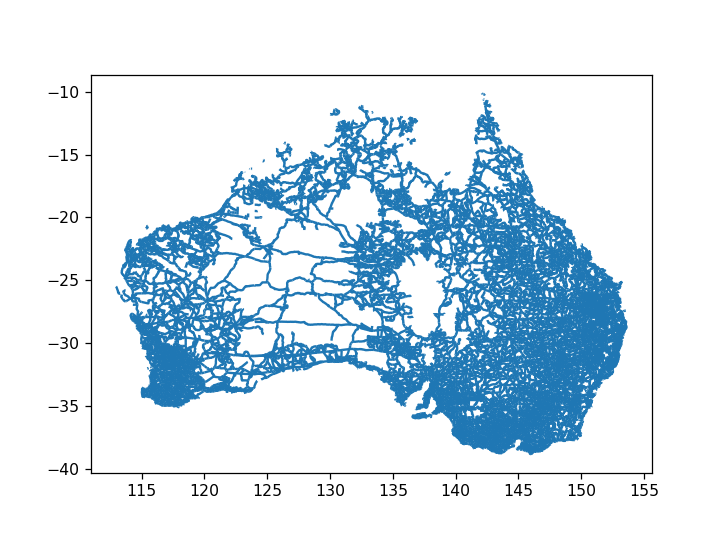

In [3]:
# Australia
AU_shape = shapely.geometry.Polygon([(100, -20), (130, -9.5), (145, -9.5),
                                            (155, -25), (153, -39),(116, -39)])
AU_df = ocean_df.loc[ocean_df['geometry'].apply(AU_shape.contains)]

AU_df.plot()
plt.show()

<IPython.core.display.Javascript object>


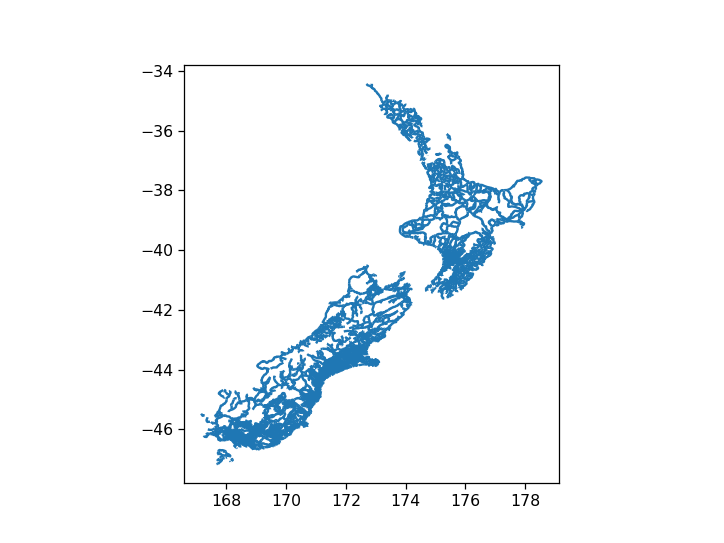

In [16]:
# New Zealand
NZ_shape = shapely.geometry.Polygon([(170, -32), (180, -38),(170,-49), (163.5, -49.5)])
NZ_df = ocean_df.loc[ocean_df['geometry'].apply(NZ_shape.contains)]

NZ_df.plot()
plt.show()

<IPython.core.display.Javascript object>


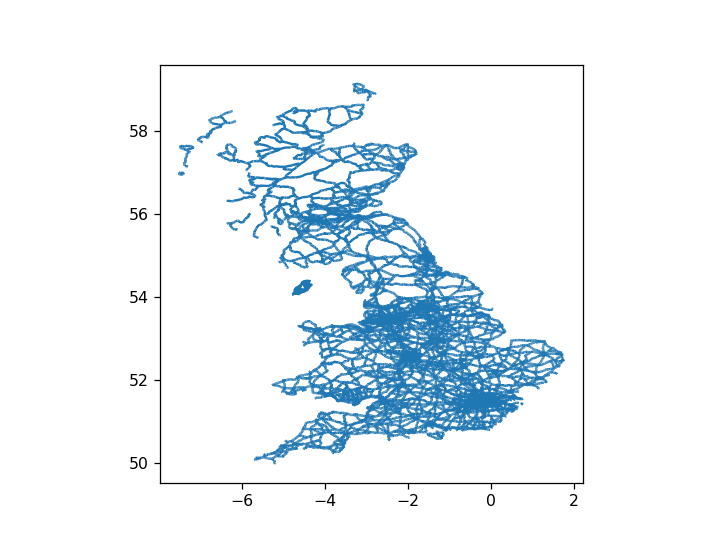

In [17]:
# United Kingdom without North Ireland
UK_shape = shapely.geometry.Polygon([(-5, 54.5), (-11, 60), (-3, 60),
                                            (2.75, 53), (-1, 50),(-6, 49)])
UK_df = europe_df.loc[europe_df['geometry'].apply(UK_shape.contains)]

UK_df.plot()
plt.show()

<IPython.core.display.Javascript object>


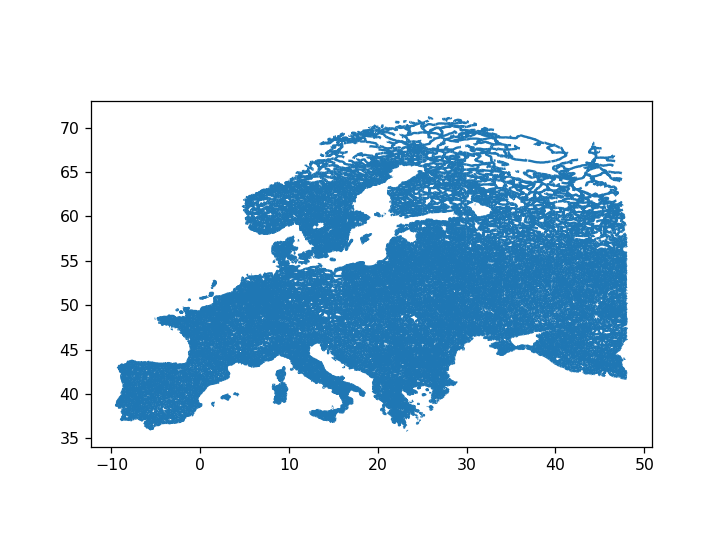

In [18]:
#Europe
EU_shape = shapely.geometry.Polygon([(20, 72), (47, 73), (49, 41.5),
                                            (31.5, 44), (23, 35),(5, 39),(-5, 36),(-10.5, 36),
                                            (-11, 49),(1, 51),(4.5, 63)])
EU_df = europe_df.loc[europe_df['geometry'].apply(EU_shape.contains)]

EU_df.plot()
plt.show()

<IPython.core.display.Javascript object>


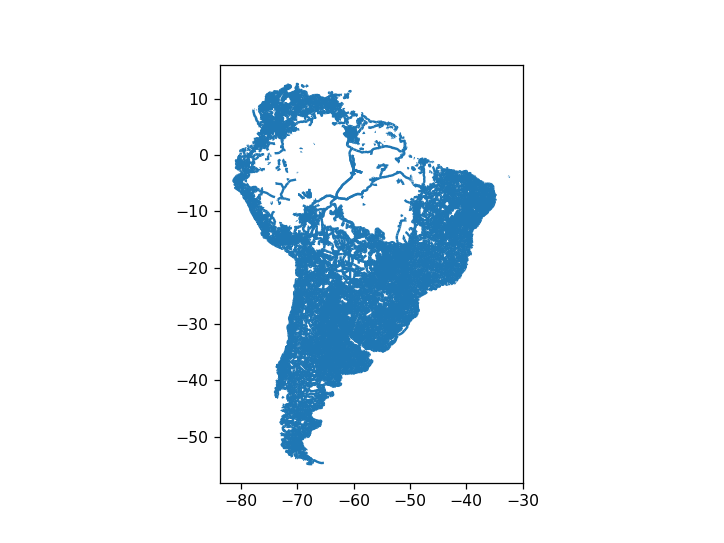

In [19]:
# South America
S_AM_shape = shapely.geometry.Polygon([(-86.5, -2), (-71, 16.5), (-27.5, -5),
                                            (-63, -52), (-64, -58),(-81, -55)])

S_AM_df = AM_df.loc[AM_df['geometry'].apply(S_AM_shape.contains)]

S_AM_df.plot()
plt.show()

<IPython.core.display.Javascript object>


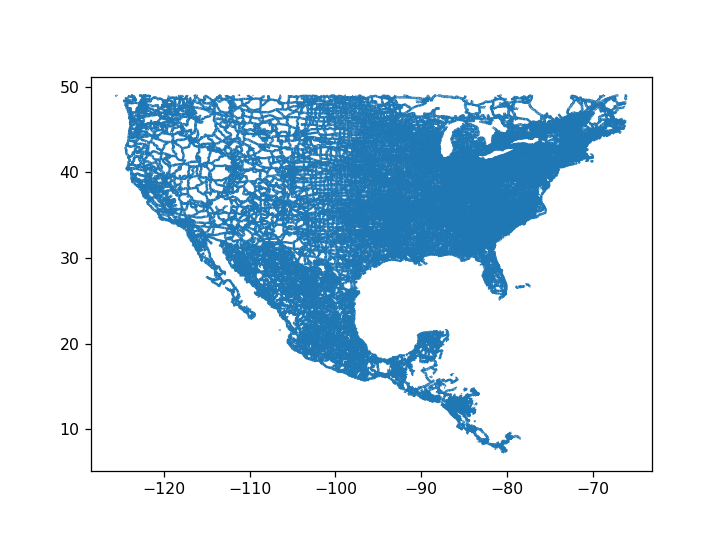

In [20]:
# North America
N_AM_shape = shapely.geometry.Polygon([(-128.5, 49), (-66, 49), (-67, 31),
                                            (-86, 23), (-78, 11),(-79, 5),(-122.5, 14.5)])

N_AM_df = AM_df.loc[AM_df['geometry'].apply(N_AM_shape.contains)]

N_AM_df.plot()
plt.show()

<IPython.core.display.Javascript object>


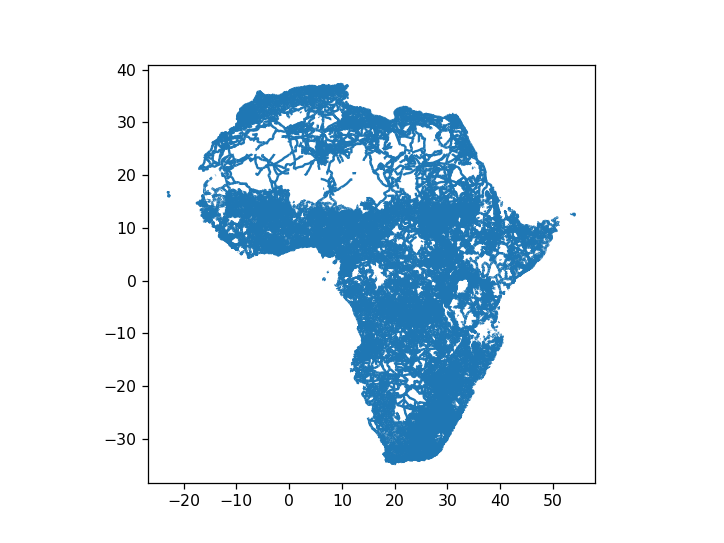

In [3]:
# Africa
AF_shape = shapely.geometry.Polygon([(-1.5, 36), (-6.5, 36), (-24.5, 17),
                                            (23.5, -41.5), (56.5, 16),(44.5, 11),(30.5, 33.5),(12.5,34.5),(11,39)])

AF_df = africa_df.loc[africa_df['geometry'].apply(AF_shape.contains)]

AF_df.plot()
plt.show()

# Create a networkx Graph

In [4]:

def crossing_index(crossing, candidate):
    """Check whether node allready exists on this place or generate new node name."""
    if candidate in crossing:
        return crossing[candidate]
    else:
        crossing[candidate] = len(crossing)
        return crossing[candidate]
        
def make_graph(dataframe):
    """make a networkx graph given a GeoPandas dataframe."""
    G=nx.Graph()

    MAX_ROAD_LEN = 50
    MIN_COLOR = 0.3
    # Save (x,y) = nodenumber in a dictionairy.
    crossings = {}
    # contains [crossing_index1, crossing_index2, length] as values
    # completely built on the idea that there is no crossing within a road
    # crossings only occur at the ends of the road (a new road starts after the crossing)
    for global_index, road_attrs in tqdm(dataframe.iterrows()):
        line = road_attrs['geometry']
        length = road_attrs['LENGTH_KM']
        # Skip multilinestring roads. Use remove_multistring to unpack them.
        try:
            road_points = list(line.coords)
        except NotImplementedError:
            print ("skipping multilinestring")
        # the roads begin and end coordinateIDs
        beginID = crossing_index(crossings, road_points[0])
        endID = crossing_index(crossings, road_points[-1])
        
        # add the roads as edges to the network
        G.add_edge(beginID, endID, ROADID = road_attrs["ROADID"], FCLASS = road_attrs["FCLASS"],
                    CRGWAY = road_attrs["CRGWAY"], NUMLANES = road_attrs["NUMLANES"], SPEEDLIMIT = road_attrs["SPEEDLIMIT"],
                  GNRALSPEED = road_attrs["GNRALSPEED"], LENGTH_KM = length)
        
    pos = {v:k for k,v in crossings.items()}
    nx.set_node_attributes(G, pos, "coords")
    
    return G
           
def plot_graph(G):
    """Plot networkx graph. Whereby position is given by coords attribute"""
    plt.figure()
    # list of all edges
    edges = [(u,v) for (u,v,d) in G.edges(data=True)]
    # positions for all nodes
    pos = nx.get_node_attributes(G, "coords")

    # nodes
    nx.draw_networkx_nodes(G,pos = pos, node_size=1, node_color='r', node_shape='v')

    # colour edges based on their weights
    edges, weights = zip(*nx.get_edge_attributes(G,'LENGTH_KM').items())
    nx.draw_networkx_edges(G, pos = pos, edgelist=edges, edge_color=weights, width=1, edge_cmap=plt.cm.Blues)
    #nx.draw(G, pos = pos)

    #small_df.plot()
    plt.show()
    
def save_graph(G, path):
    """Save the graph at the given path in pickle format"""
    nx.write_gpickle(G, path, 2)


28395it [00:03, 8605.54it/s]


<IPython.core.display.Javascript object>


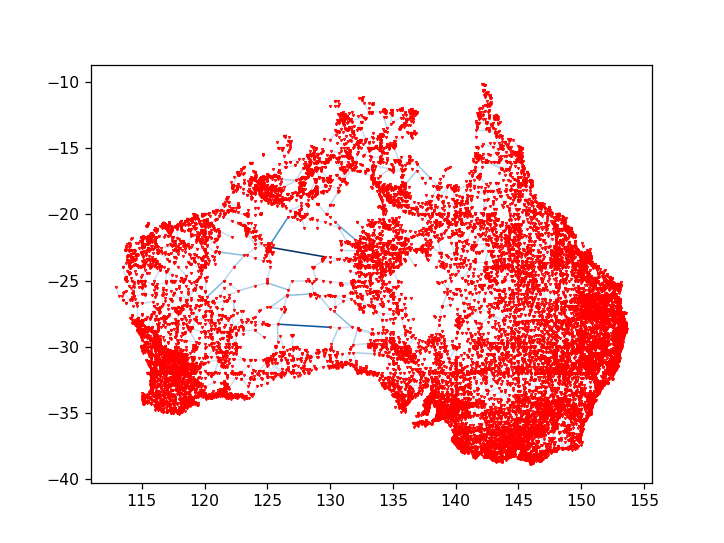

In [6]:
Graph = make_graph(AU_df)
plot_graph(Graph, )
save_graph(Graph, "databases/australia2")

13259it [00:01, 7716.33it/s]


<IPython.core.display.Javascript object>


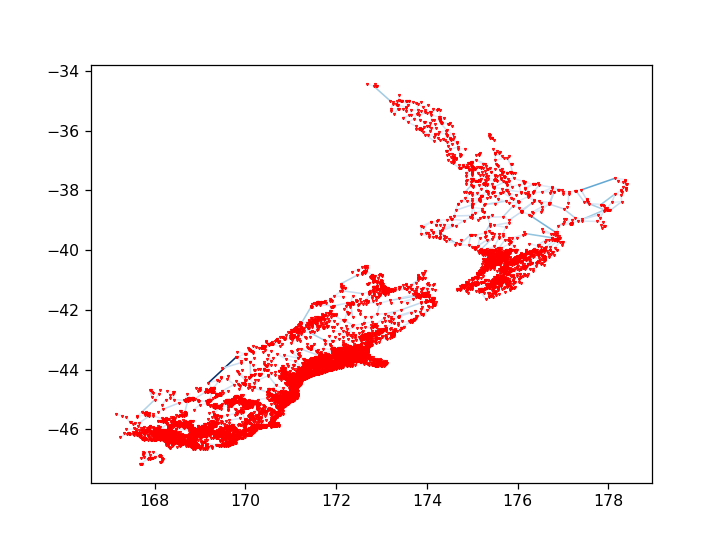

In [26]:
Graph = make_graph(NZ_df)
plot_graph(Graph)
save_graph(Graph, "databases/newzealand")

29141it [00:04, 7092.94it/s]

skipping multilinestring


33821it [00:04, 7240.86it/s]

skipping multilinestring


54655it [00:07, 7615.69it/s]


<IPython.core.display.Javascript object>


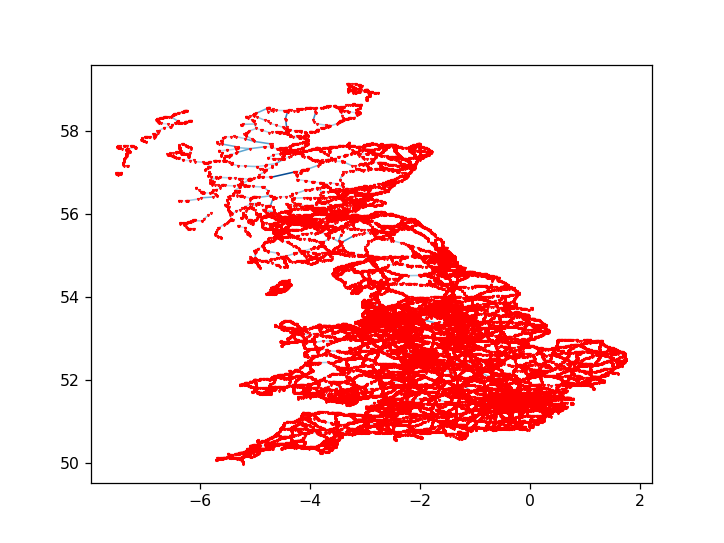

In [27]:
Graph = make_graph(UK_df)
plot_graph(Graph)
save_graph(Graph, "databases/UK")

10726it [00:01, 7545.00it/s]

skipping multilinestring


37148it [00:04, 8061.05it/s]

skipping multilinestring


70896it [00:08, 8266.68it/s]


<IPython.core.display.Javascript object>


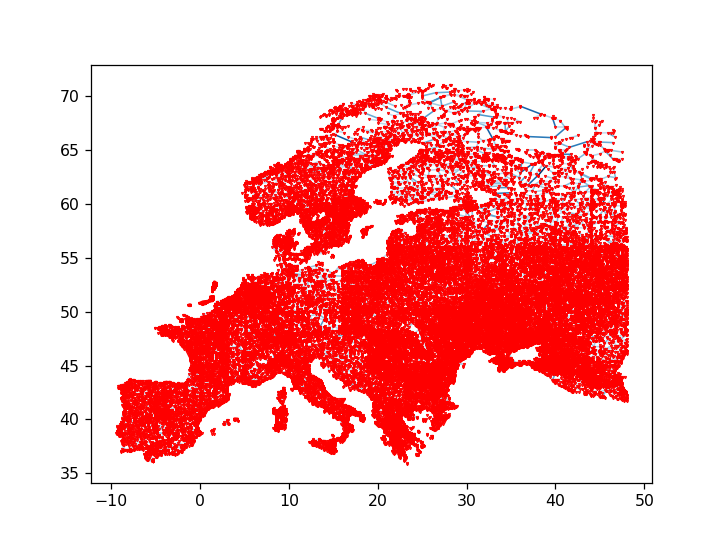

In [28]:
Graph = make_graph(EU_df)
plot_graph(Graph)
save_graph(Graph, "databases/europa")

41692it [00:04, 8693.46it/s]


<IPython.core.display.Javascript object>


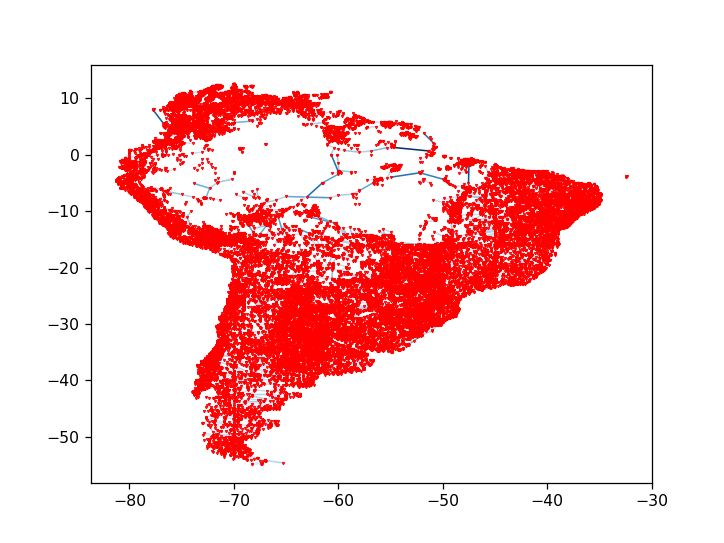

In [29]:
Graph = make_graph(S_AM_df)
plot_graph(Graph)
save_graph(Graph, "databases/southamerica")


348890it [00:41, 8342.98it/s]


<IPython.core.display.Javascript object>


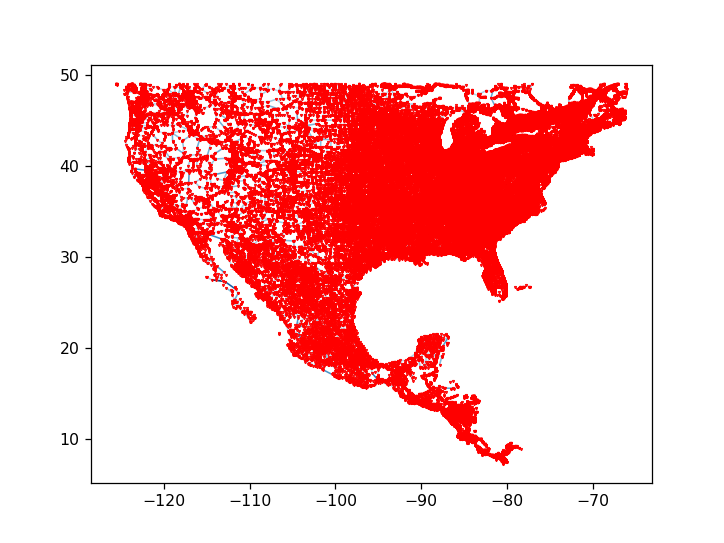

In [30]:
Graph = make_graph(N_AM_df)
plot_graph(Graph)
save_graph(Graph, "databases/northamerica")


1it [00:00,  4.88it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


194it [00:00, 612.83it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


1081it [00:00, 2090.68it/s]

skipping multilinestring


3429it [00:00, 3735.19it/s]

skipping multilinestring


3995it [00:01, 3923.33it/s]

skipping multilinestring


4532it [00:01, 4051.83it/s]

skipping multilinestring
skipping multilinestring


5062it [00:01, 4131.11it/s]

skipping multilinestring
skipping multilinestring


6102it [00:01, 4279.63it/s]

skipping multilinestring


7417it [00:01, 4560.56it/s]

skipping multilinestring


8013it [00:01, 4640.98it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


8604it [00:01, 4709.84it/s]

skipping multilinestring
skipping multilinestring


13083it [00:02, 5132.43it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


13722it [00:02, 5174.72it/s]

skipping multilinestring


14356it [00:02, 5181.08it/s]

skipping multilinestring
skipping multilinestring


15578it [00:02, 5218.51it/s]

skipping multilinestring


16184it [00:03, 5243.93it/s]

skipping multilinestring


16778it [00:03, 5264.06it/s]

skipping multilinestring


18011it [00:03, 5292.83it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


19784it [00:03, 5341.80it/s]

skipping multilinestring


22377it [00:04, 5449.01it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


23607it [00:04, 5441.48it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


24185it [00:04, 5448.82it/s]

skipping multilinestring
skipping multilinestring


24763it [00:04, 5437.11it/s]

skipping multilinestring
skipping multilinestring


25890it [00:04, 5444.88it/s]

skipping multilinestring


27808it [00:05, 5500.34it/s]

skipping multilinestring
skipping multilinestring


32358it [00:05, 5613.80it/s]

skipping multilinestring


33689it [00:05, 5648.23it/s]

skipping multilinestring
skipping multilinestring


37673it [00:06, 5723.88it/s]

skipping multilinestring
skipping multilinestring


40973it [00:07, 5771.91it/s]

skipping multilinestring
skipping multilinestring


41605it [00:07, 5766.79it/s]

skipping multilinestring


44790it [00:07, 5793.12it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


45429it [00:07, 5800.59it/s]

skipping multilinestring
skipping multilinestring


48023it [00:08, 5822.12it/s]

skipping multilinestring
skipping multilinestring


49293it [00:08, 5823.49it/s]

skipping multilinestring
skipping multilinestring


49902it [00:08, 5822.02it/s]

skipping multilinestring


50499it [00:08, 5813.07it/s]

skipping multilinestring
skipping multilinestring


51685it [00:08, 5815.39it/s]

skipping multilinestring
skipping multilinestring


52853it [00:09, 5815.62it/s]

skipping multilinestring


55141it [00:09, 5801.40it/s]

skipping multilinestring
skipping multilinestring


55795it [00:09, 5808.92it/s]

skipping multilinestring
skipping multilinestring


56969it [00:09, 5809.89it/s]

skipping multilinestring


58923it [00:10, 5830.28it/s]

skipping multilinestring


59551it [00:10, 5834.52it/s]

skipping multilinestring


62509it [00:10, 5820.61it/s]

skipping multilinestring
skipping multilinestring


63672it [00:10, 5820.25it/s]

skipping multilinestring


65455it [00:11, 5808.04it/s]

skipping multilinestring
skipping multilinestring


66619it [00:11, 5807.00it/s]

skipping multilinestring


67193it [00:11, 5806.06it/s]

skipping multilinestring


67766it [00:11, 5804.55it/s]

skipping multilinestring


68359it [00:11, 5805.25it/s]

skipping multilinestring


68980it [00:11, 5808.30it/s]

skipping multilinestring
skipping multilinestring


69568it [00:11, 5804.68it/s]

skipping multilinestring


70178it [00:12, 5806.77it/s]

skipping multilinestring
skipping multilinestring


72043it [00:12, 5813.06it/s]

skipping multilinestring


72653it [00:12, 5815.23it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


73260it [00:12, 5813.25it/s]

skipping multilinestring


73852it [00:12, 5813.28it/s]

skipping multilinestring


76922it [00:13, 5822.74it/s]

skipping multilinestring


78169it [00:13, 5827.37it/s]

skipping multilinestring


79411it [00:13, 5832.17it/s]

skipping multilinestring
skipping multilinestring


80641it [00:13, 5833.61it/s]

skipping multilinestring


81247it [00:13, 5834.92it/s]

skipping multilinestring


81852it [00:14, 5835.33it/s]

skipping multilinestring


83103it [00:14, 5839.65it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


83708it [00:14, 5830.27it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


85449it [00:14, 5826.47it/s]

skipping multilinestring


89019it [00:15, 5827.24it/s]

skipping multilinestring


89602it [00:15, 5824.34it/s]

skipping multilinestring


90172it [00:15, 5823.22it/s]

skipping multilinestring
skipping multilinestring


92655it [00:15, 5829.67it/s]

skipping multilinestring
skipping multilinestring


93280it [00:15, 5832.03it/s]

skipping multilinestring


94564it [00:16, 5838.75it/s]

skipping multilinestring


95192it [00:16, 5838.69it/s]

skipping multilinestring


97119it [00:16, 5848.60it/s]

skipping multilinestring


97751it [00:16, 5849.79it/s]

skipping multilinestring
skipping multilinestring


98375it [00:16, 5845.95it/s]

skipping multilinestring
skipping multilinestring


100639it [00:17, 5824.10it/s]

skipping multilinestring


101159it [00:17, 5818.27it/s]

skipping multilinestring


102350it [00:17, 5819.34it/s]

skipping multilinestring
skipping multilinestring


103525it [00:17, 5819.63it/s]

skipping multilinestring


105215it [00:18, 5808.31it/s]

skipping multilinestring


105747it [00:18, 5803.10it/s]

skipping multilinestring
skipping multilinestring


107261it [00:18, 5781.46it/s]

skipping multilinestring


112085it [00:19, 5755.26it/s]

skipping multilinestring


114458it [00:19, 5756.09it/s]

skipping multilinestring


115603it [00:20, 5755.36it/s]

skipping multilinestring


116796it [00:20, 5757.02it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


117375it [00:20, 5748.82it/s]

skipping multilinestring


118423it [00:20, 5731.82it/s]

skipping multilinestring
skipping multilinestring


118907it [00:20, 5721.55it/s]

skipping multilinestring


119365it [00:20, 5715.34it/s]

skipping multilinestring
skipping multilinestring


119820it [00:20, 5708.88it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


121216it [00:21, 5686.38it/s]

skipping multilinestring


139019it [00:24, 5662.61it/s]

skipping multilinestring
skipping multilinestring


139584it [00:24, 5660.56it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


140165it [00:24, 5661.00it/s]

skipping multilinestring


140749it [00:24, 5661.55it/s]

skipping multilinestring
skipping multilinestring


141331it [00:24, 5662.01it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


142508it [00:25, 5660.32it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


143073it [00:25, 5652.72it/s]

skipping multilinestring
skipping multilinestring


144116it [00:25, 5648.52it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


144665it [00:25, 5647.74it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


152694it [00:26, 5665.32it/s]

skipping multilinestring


156948it [00:27, 5673.15it/s]

skipping multilinestring


157609it [00:27, 5676.38it/s]

skipping multilinestring


158943it [00:27, 5683.18it/s]

skipping multilinestring


160917it [00:28, 5689.98it/s]

skipping multilinestring


161560it [00:28, 5691.51it/s]

skipping multilinestring


162897it [00:28, 5698.27it/s]

skipping multilinestring


163547it [00:28, 5700.53it/s]

skipping multilinestring
skipping multilinestring


164192it [00:28, 5698.65it/s]

skipping multilinestring
skipping multilinestring


164802it [00:28, 5696.94it/s]

skipping multilinestring


165387it [00:29, 5696.74it/s]

skipping multilinestring


166634it [00:29, 5700.13it/s]

skipping multilinestring
skipping multilinestring


167237it [00:29, 5699.38it/s]

skipping multilinestring


167898it [00:29, 5702.41it/s]

skipping multilinestring


168520it [00:29, 5704.02it/s]

skipping multilinestring


169754it [00:29, 5705.92it/s]

skipping multilinestring


171622it [00:30, 5710.03it/s]

skipping multilinestring


172270it [00:30, 5712.44it/s]

skipping multilinestring
skipping multilinestring


174105it [00:30, 5713.02it/s]

skipping multilinestring


174715it [00:30, 5714.15it/s]

skipping multilinestring


175371it [00:30, 5716.77it/s]

skipping multilinestring


175984it [00:30, 5715.76it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


177723it [00:31, 5706.80it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


178261it [00:31, 5700.84it/s]

skipping multilinestring


178800it [00:31, 5699.81it/s]

skipping multilinestring


180349it [00:31, 5693.88it/s]

skipping multilinestring


180860it [00:31, 5691.20it/s]

skipping multilinestring
skipping multilinestring


181398it [00:31, 5690.09it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


181911it [00:31, 5685.38it/s]

skipping multilinestring
skipping multilinestring


182402it [00:32, 5680.54it/s]

skipping multilinestring
skipping multilinestring


182876it [00:32, 5671.34it/s]

skipping multilinestring


183313it [00:32, 5665.09it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


183819it [00:32, 5663.10it/s]

skipping multilinestring
skipping multilinestring


184384it [00:32, 5663.02it/s]

skipping multilinestring


186238it [00:32, 5667.49it/s]

skipping multilinestring


186877it [00:32, 5669.55it/s]

skipping multilinestring


188889it [00:33, 5678.53it/s]

skipping multilinestring


190238it [00:33, 5684.76it/s]

skipping multilinestring


192453it [00:33, 5694.05it/s]


<IPython.core.display.Javascript object>


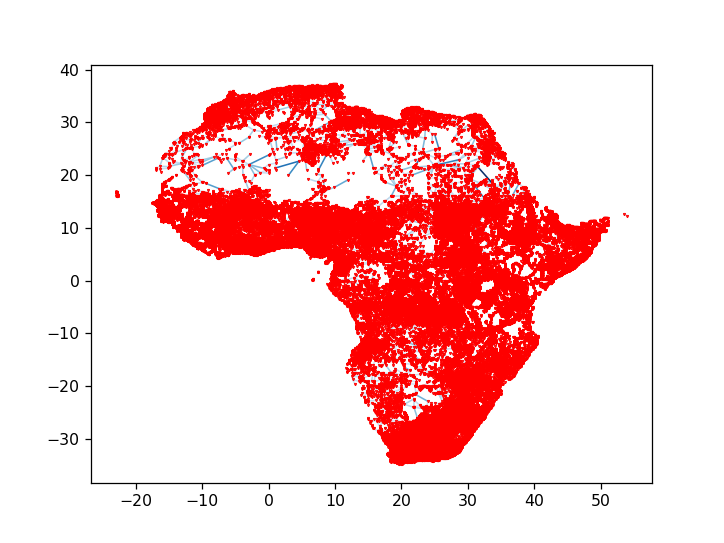

In [6]:
Graph = make_graph(AF_df)
plot_graph(Graph)
save_graph(Graph, "databases/africa")

In [5]:

def remove_multistring(dataframe):
    """ Unpack the multi linestring into single row Linestring (Does keep the linestrings, they just get skipped)."""
    listy = []

    # Loop over every entry in the dataframe and check for multilinestrings
    for _ , road_attrs in tqdm(dataframe.iterrows(), desc = "iterating objects", position = 0, total = 367421):
        if isinstance(road_attrs['geometry'],  shapely.geometry.multilinestring.MultiLineString):
            for element in road_attrs['geometry']:
                entrygood = road_attrs
                entrygood['geometry'] = element
                listy.append(entrygood)
                
    dataframe.append(listy)   
    
    return dataframe

AF_df = remove_multistring(AF_df)

iterating objects:  52%|█████████▍        | 192453/367421 [00:11<00:10, 16506.43it/s]
